# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person', root_dir="/mnt/storage/Datasets/folktables")
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: int = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ## Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    ascending = [True, True, True, False, False, True, False, True, False]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True,columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

X_train_f, X_test_f = train_test_split(data_original[feature_names], test_size=0.2, random_state=0)

In [2]:
data.columns

Index(['AGEP', 'HINS1_2', 'HINS2_2', 'HINS4_2', 'CIT_2', 'CIT_3', 'CIT_4',
       'CIT_5', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0',
       'COW_7.0', 'COW_8.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0',
       'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0',
       'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0',
       'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0',
       'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 'MAR_2', 'MAR_3',
       'MAR_4', 'MAR_5', 'SEX_2', 'RAC1P_2', 'RAC1P_3', 'RAC1P_4', 'RAC1P_5',
       'RAC1P_6', 'RAC1P_7', 'RAC1P_8', 'RAC1P_9', 'ENG_2.0', 'ENG_3.0',
       'ENG_4.0', 'ENG_nan'],
      dtype='object')

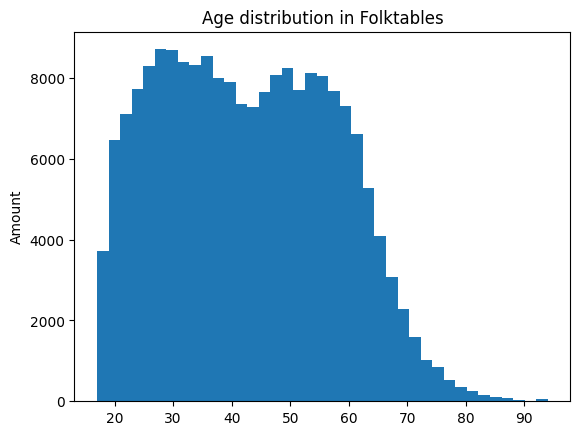

In [3]:
### Age plot to determine which kind of Scaler would be the most appropriate
import matplotlib.pyplot as plt

cols_to_scale = ["AGEP"]

plt.hist(data[cols_to_scale].values, bins = 39)
plt.title("Age distribution in Folktables")
# plt.xlabel("Age")
plt.ylabel("Amount")

plt.show()


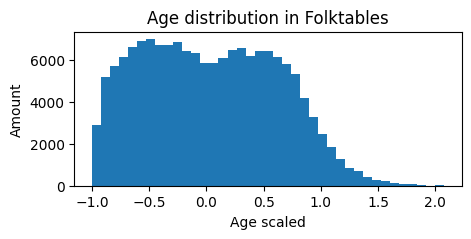

In [4]:
## We decideded on RobustScaler as we have quite skrewed distribution to the left
## we want to keep that distribution
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train["AGEP"] = scaler.fit_transform(X_train[["AGEP"]])
X_test["AGEP"] = scaler.transform(X_test[["AGEP"]])

X_train_f["AGEP"] = scaler.fit_transform(X_train_f[["AGEP"]])
X_test_f["AGEP"] = scaler.transform(X_test_f[["AGEP"]])

plt.figure(figsize=(5,2))
plt.hist(X_train["AGEP"].values, bins = 39)
plt.title("Age distribution in Folktables")
plt.xlabel("Age scaled")
plt.ylabel("Amount")
plt.show()

## Task 1

In [5]:
from sklearn.linear_model import LogisticRegression

LogR = LogisticRegression(penalty ="elasticnet", C= 0.1, solver = "saga", l1_ratio=0.2).fit(X_train, y_train)

## penalty is elasticnet to get advantage of both l1 and l2 regularizations
## C = 0.1 is the strongest regularization that doesn't give deminishing returns
## solver saga is the only solver compatible with the elasticnet penalty
##l1 ratio is the most optimal one after testing

LogR.predict(X_test)
LogR.predict_proba(X_test)
LogR.score(X_test, y_test)


0.7702195078322643

#Answers: 
- Train a logistic regression, The age is rescaled with RobustScaler as the age it heavily right tailed skrewed. In this case we have few people with age 70,80,90 relatively to age 20,30,40... 
- Score 76.961 %


In [6]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=150, min_samples_split = 0.01, min_samples_leaf= 0.01,  max_depth = 4, criterion = "gini", random_state = 0)
# clf = tree.DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf=0.001, max_depth=6, random_state=42)
clf = clf.fit(X_train_f, y_train)

clf.score(X_test_f, y_test)


0.7672808115912402

In [7]:
from sklearn.metrics import confusion_matrix

y_pred_logR = LogR.predict(X_test)

y_pred_clf = clf.predict(X_test_f)

cm_logR = confusion_matrix(y_test, y_pred_logR)
cm_clf = confusion_matrix(y_test, y_pred_clf)

cm_log_male = confusion_matrix(y_test[group_test == 1], y_pred_logR[group_test==1])
cm_log_female = confusion_matrix(y_test[group_test == 2], y_pred_logR[group_test==2])

cm_clf_male = confusion_matrix(y_test[group_test == 1], y_pred_clf[group_test==1])
cm_clf_female = confusion_matrix(y_test[group_test == 2], y_pred_clf[group_test==2])

In [8]:
## Statistical Parity


## (TP + FN) / (TP + FN + FP + TN)
statistical_parity_log = {
    "male" : round(cm_log_male.sum(axis=0)[1]/len(y_test[group_test == 1]),2),
    "female" : round(cm_log_female.sum(axis=0)[1]/len(y_test[group_test == 2]),2)
}


statistical_parity_clf = {
    "male" : round(cm_clf_male.sum(axis=0)[1]/len(y_test[group_test == 1]),2),
    "female" : round(cm_clf_female.sum(axis=0)[1]/len(y_test[group_test == 2]),2)
}

## Equalized Odds

## TP / (TP + FN)
## FP / (FP + TN)

equalized_odds_log= {
    "true_positive":
        {
            "male": round(cm_log_male[1,1]/cm_log_male.sum(axis=0)[1],2),
            "female": round(cm_log_female[1,1]/cm_log_female.sum(axis=0)[1],2)
        },
    "false_positive":
        {
            "male": round(cm_log_male[0,1]/cm_log_male.sum(axis=0)[0],2),
            "female": round(cm_log_female[0,1]/cm_log_female.sum(axis=0)[0],2)
        }
}

equalized_odds_clf = {
    "true_positive":
        {
            "male": round(cm_clf_male[1,1]/cm_clf_male.sum(axis=0)[1],2),
            "female": round(cm_clf_female[1,1]/cm_clf_female.sum(axis=0)[1],2)
        },
    "false_positive":
        {
            "male": round(cm_clf_male[0,1]/cm_clf_male.sum(axis=0)[0],2),
            "female": round(cm_clf_female[0,1]/cm_clf_female.sum(axis=0)[0],2)
        }
}

## Equalized Outcomes

## TP / (TP + FP)
## FN / (TN + FN)

equalized_outcomes_log = {
    "true_positive":
        {
            "male": round(cm_log_male[1,1]/cm_log_male.sum(axis=1)[1],2),
            "female": round(cm_log_female[1,1]/cm_log_female.sum(axis=1)[1],2)
        },
    "false_negative":
        {
            "male": round(cm_log_male[1,0]/cm_log_male.sum(axis=1)[0],2),
            "female": round(cm_log_female[1,0]/cm_log_female.sum(axis=1)[0],2)
        }
}

equalized_outcomes_clf = {
    "true_positive":
        {
            "male": round(cm_clf_male[1,1]/cm_clf_male.sum(axis=1)[1],2),
            "female": round(cm_clf_female[1,1]/cm_clf_female.sum(axis=1)[1],2)
        },
    "false_negative":
        {
            "male": round(cm_clf_male[1,0]/cm_clf_male.sum(axis=1)[0],2),
            "female": round(cm_clf_female[1,0]/cm_clf_female.sum(axis=1)[0],2)
        }
}

In [9]:
print("Statistical Parity Logistic Regression: ", statistical_parity_log)
print("Statistical Parity Decision Tree: ", statistical_parity_clf)
print("\n")
print("Equalized Odds Logistic Regression: ", equalized_odds_log)
print("Equalized Odds Decision Tree: ", equalized_odds_clf)

print("\n")
print("Equalized Outcomes Logistic Regression: ", equalized_outcomes_log)
print("Equalized Outcomes Decision Tree: ", equalized_outcomes_clf)

Statistical Parity Logistic Regression:  {'male': 0.64, 'female': 0.52}
Statistical Parity Decision Tree:  {'male': 0.66, 'female': 0.61}


Equalized Odds Logistic Regression:  {'true_positive': {'male': 0.81, 'female': 0.73}, 'false_positive': {'male': 0.35, 'female': 0.29}}
Equalized Odds Decision Tree:  {'true_positive': {'male': 0.8, 'female': 0.69}, 'false_positive': {'male': 0.39, 'female': 0.49}}


Equalized Outcomes Logistic Regression:  {'true_positive': {'male': 0.85, 'female': 0.78}, 'false_negative': {'male': 0.23, 'female': 0.22}}
Equalized Outcomes Decision Tree:  {'true_positive': {'male': 0.87, 'female': 0.86}, 'false_negative': {'male': 0.2, 'female': 0.13}}


C:\Users\User\AppData\Local\Temp\ipykernel_8280\3380352265.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,0].set_xticklabels(["", ""])


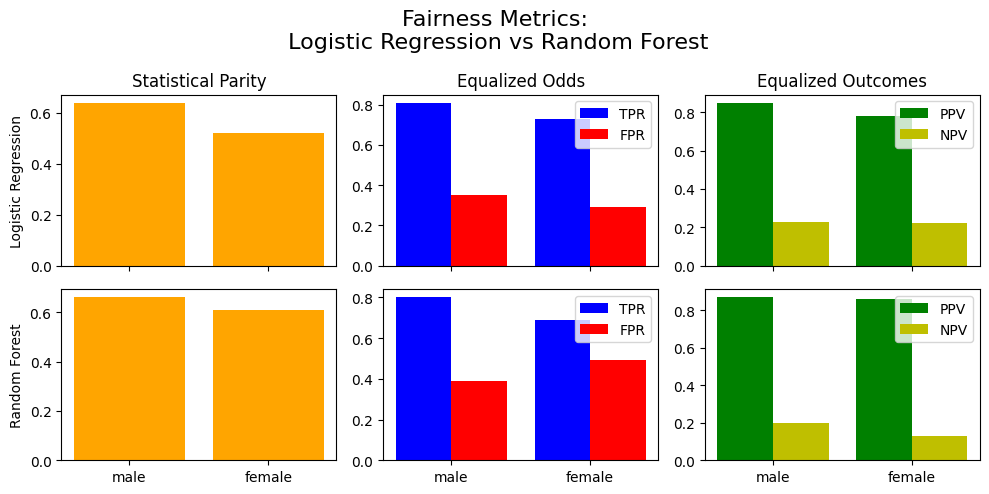

In [10]:
fig,ax = plt.subplots(2,3, figsize=(10,5))

#bar plot statistical parities for both models
ax[0,0].bar(statistical_parity_log.keys(), statistical_parity_log.values(), color='orange')
ax[0,0].set_xticklabels(["", ""])
ax[1,0].bar(statistical_parity_clf.keys(), statistical_parity_clf.values(), color='orange')
ax[0,0].set_title("Statistical Parity")
ax[0,0].set_ylabel("Logistic Regression")
ax[1,0].set_ylabel("Random Forest")

#bar plot for equalized odds for both models
ax[0,1].bar(np.arange(2), equalized_odds_log["true_positive"].values(), color='b', width=0.4, label="TPR")
ax[0,1].bar(np.arange(2)+0.4, equalized_odds_log["false_positive"].values(), color='r', width=0.4, label="FPR")
ax[0,1].set_xticks([0.2,1.2], ["", ""])
ax[0,1].set_title("Equalized Odds")
ax[0,1].legend()

ax[1,1].bar(np.arange(2), equalized_odds_clf["true_positive"].values(), color='b', width=0.4, label="TPR")
ax[1,1].bar(np.arange(2)+0.4, equalized_odds_clf["false_positive"].values(), color='r', width=0.4, label="FPR")
ax[1,1].set_xticks([0.2,1.2], ["male", "female"])
ax[1,1].legend()

#bar plot for equalized outcomesfor both models
ax[0,2].bar(np.arange(2), equalized_outcomes_log["true_positive"].values(), color='g', width=0.4, label="PPV")
ax[0,2].bar(np.arange(2)+0.4, equalized_outcomes_log["false_negative"].values(), color='y', width=0.4, label="NPV")
ax[0,2].set_xticks([0.2,1.2], ["", ""])
ax[0,2].set_title("Equalized Outcomes")
ax[0,2].legend()

ax[1,2].bar(np.arange(2), equalized_outcomes_clf["true_positive"].values(), color='g', width=0.4, label="PPV")
ax[1,2].bar(np.arange(2)+0.4, equalized_outcomes_clf["false_negative"].values(), color='y', width=0.4, label="NPV")
ax[1,2].set_xticks([0.2,1.2], ["male", "female"])
ax[1,2].legend()

fig.suptitle("Fairness Metrics:\n Logistic Regression vs Random Forest", fontsize=16)

fig.tight_layout()

plt.show()

### TPR: True Positive Rate
### FPR: False Positive Rate

### PPV: Positive Predictive Value
### NPV: Negative Predictive Value

In [13]:
from sklearn.metrics import roc_curve, auc




def plot_roc_curve(y_true, y_pred=None, ax=None, color='b', group="group"):
    
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    if ax is None:
        ax = plt.gca()
    
    ax.plot(fpr, tpr, color=color, label = f'AUC {group} = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1],'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

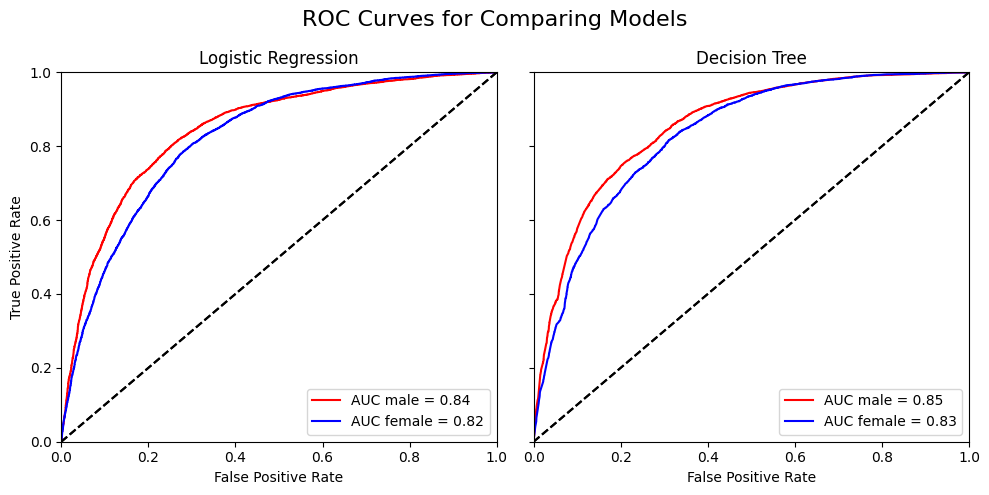

In [14]:
from sklearn.metrics import roc_curve, auc

y_pred_proba_logR = LogR.predict_proba(X_test)[:,1]
y_pred_proba_clf = clf.predict_proba(X_test_f)[:,1]


fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

plot_roc_curve(y_test[group_test==1], y_pred_proba_logR[group_test==1], ax=ax[0], color='r', group="male")
plot_roc_curve(y_test[group_test==2], y_pred_proba_logR[group_test==2], ax=ax[0], color='b', group="female")
ax[0].set_title("Logistic Regression")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend()


plot_roc_curve(y_test[group_test==1], y_pred_proba_clf[group_test==1], ax=ax[1], color='r', group="male")
plot_roc_curve(y_test[group_test==2], y_pred_proba_clf[group_test==2], ax=ax[1], color='b', group="female")
ax[1].set_title("Decision Tree")
ax[1].set_xlabel("False Positive Rate")
ax[1].legend()

plt.suptitle("ROC Curves for Comparing Models", fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
##predict with different thresholds if group is different
def predict_with_threshold(y_pred_proba, threshold, group_list, target_group):
    y_pred = np.zeros(len(y_pred_proba))
    for i in range(len(y_pred_proba)):
        if group_list[i] == target_group:
            if y_pred_proba[i] > threshold:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
        else:
            if y_pred_proba[i] > 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred
    

In [16]:
threshold_points = np.linspace(0.1,0.5,1000)

statistical_parity_post_log = {
    "male": [],
    "female": []
}

statistical_parity_post_clf = {
    "male": [],
    "female": []
}

for threshold in threshold_points:
    y_pred_log_post = predict_with_threshold(y_pred_proba_logR, threshold, group_test, 2)
    y_pred_clf_post = predict_with_threshold(y_pred_proba_clf, threshold, group_test, 2)

    cm_log_post_male = confusion_matrix(y_test[group_test == 1], y_pred_log_post[group_test==1])
    cm_log_post_female = confusion_matrix(y_test[group_test == 2], y_pred_log_post[group_test==2])
    statistical_parity_post_log["male"].append(round(cm_log_post_male.sum(axis=0)[1]/len(y_test[group_test == 1]),2))
    statistical_parity_post_log["female"].append(round(cm_log_post_female.sum(axis=0)[1]/len(y_test[group_test == 2]),2))
    
    cm_clf_post_male = confusion_matrix(y_test[group_test == 1], y_pred_clf_post[group_test==1])
    cm_clf_post_female = confusion_matrix(y_test[group_test == 2], y_pred_clf_post[group_test==2])
    statistical_parity_post_clf["male"].append(round(cm_clf_post_male.sum(axis=0)[1]/len(y_test[group_test == 1]),2))
    statistical_parity_post_clf["female"].append(round(cm_clf_post_female.sum(axis=0)[1]/len(y_test[group_test == 2]),2))
    
    

                                       Statistical Parity for different thresholds


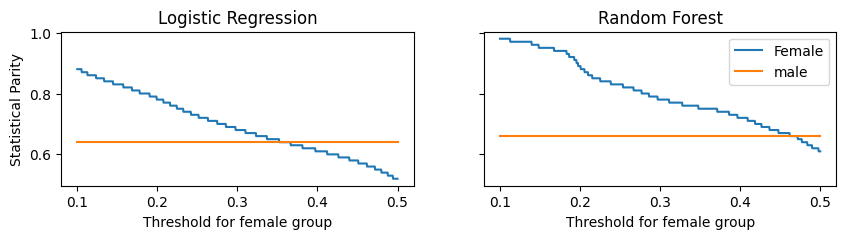

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10,2), sharey=True)

print("                                       Statistical Parity for different thresholds")
ax[0].plot(threshold_points, statistical_parity_post_log["female"], label="Female")
ax[0].plot(threshold_points, statistical_parity_post_log["male"], label="male")
ax[0].set_xlabel("Threshold for female group")
ax[0].set_ylabel("Statistical Parity")
ax[0].set_title("Logistic Regression")

ax[1].plot(threshold_points, statistical_parity_post_clf["female"], label="Female")
ax[1].plot(threshold_points, statistical_parity_post_clf["male"], label="male")
ax[1].set_xlabel("Threshold for female group")
ax[1].set_title("Random Forest")
#plt.suptitle("Statistical Parity for different thresholds", fontsize=16)
plt.legend()
plt.show()

Best threshold for Statistical Parity:
- around 0.35 for logistic
- around 0.45 for Random Forest

In [18]:
y_pred_log_post = predict_with_threshold(y_pred_proba_logR, 0.36, group_test, 2)
y_pred_clf_post = predict_with_threshold(y_pred_proba_clf, 0.47, group_test, 2)

In [19]:
cm_log_post = confusion_matrix(y_test, y_pred_log_post)
cm_clf_post = confusion_matrix(y_test, y_pred_clf_post)


print("Accuracy logistic: ", cm_log_post[1,1]/cm_log_post.sum(axis=0)[1])
print("Accuracy random forest: ", cm_clf_post[1,1]/cm_clf_post.sum(axis=0)[1])

Accuracy logistic:  0.7461538461538462
Accuracy random forest:  0.7403603952722341


In [20]:
cm_log_post_male = confusion_matrix(y_test[group_test == 1], y_pred_log_post[group_test==1])
cm_log_post_female = confusion_matrix(y_test[group_test == 2], y_pred_log_post[group_test==2])
cm_clf_post_male = confusion_matrix(y_test[group_test == 1], y_pred_clf_post[group_test==1])
cm_clf_post_female = confusion_matrix(y_test[group_test == 2], y_pred_clf_post[group_test==2])

In [21]:
statistical_parity_post_log = {
    "male" : round(cm_log_post_male.sum(axis=0)[1]/len(y_test[group_test == 1]),2),
    "female" : round(cm_log_post_female.sum(axis=0)[1]/len(y_test[group_test == 2]),2)
}


statistical_parity_clf = {
    "male" : round(cm_clf_post_male.sum(axis=0)[1]/len(y_test[group_test == 1]),2),
    "female" : round(cm_clf_post_female.sum(axis=0)[1]/len(y_test[group_test == 2]),2)
}


print("Statistical Parity Logistic Regression: \n", statistical_parity_post_log)
print("Statistical Parity Random Forest: \n", statistical_parity_clf)

Statistical Parity Logistic Regression: 
 {'male': 0.64, 'female': 0.64}
Statistical Parity Random Forest: 
 {'male': 0.66, 'female': 0.66}


## Task 2

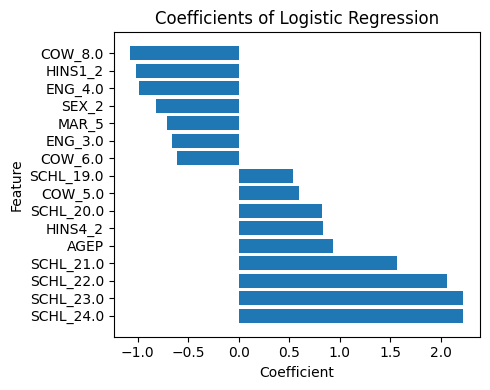

In [22]:
coefficients = pd.DataFrame(LogR.coef_.reshape(55,1), index=X_train.columns, columns=["Coefficient"]).sort_values(by="Coefficient", ascending=False)
important_coefficients = coefficients[np.abs(coefficients["Coefficient"]) > 0.5]
fig, ax = plt.subplots(1,1, figsize=(5,4))
plt.barh(important_coefficients.index, important_coefficients["Coefficient"])
plt.title("Coefficients of Logistic Regression")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [23]:
X_test.iloc[2:3,:][important_coefficients.index]

,SCHL_24.0,SCHL_23.0,SCHL_22.0,SCHL_21.0,AGEP,HINS4_2,SCHL_20.0,COW_5.0,SCHL_19.0,COW_6.0,ENG_3.0,MAR_5,SEX_2,ENG_4.0,HINS1_2,COW_8.0
306289,False,False,False,True,-0.36,True,False,False,False,False,False,True,True,False,False,False


In [24]:
print("Real Value: ", y_test[2])
print(LogR.predict_proba(X_test.iloc[2:3,:]))
print("Predicted Value: ", LogR.predict(X_test.iloc[2:3,:]))

Real Value:  False
[[0.39827006 0.60172994]]
Predicted Value:  [ True]


In [25]:
counterfactual = X_test.iloc[2:3,:]
counterfactual["COW_8.0"] = True

print(LogR.predict_proba(counterfactual))
print("Predicted Value: ", LogR.predict(counterfactual))


[[0.65920042 0.34079958]]
Predicted Value:  [False]


C:\Users\User\AppData\Local\Temp\ipykernel_8280\2294441515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counterfactual["COW_8.0"] = True


## Task 3

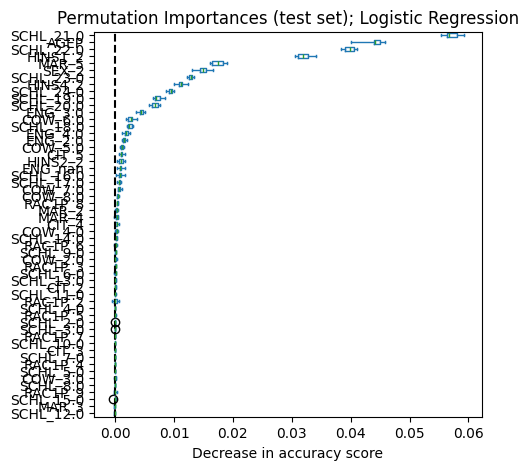

In [26]:
from sklearn.inspection import permutation_importance
#permutation_importance(LogR, X_test, y_test, n_repeats = 30, random_state = 0)
result = permutation_importance(
    LogR, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances_log = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)

# Set the figure size
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the boxplot
importances_log.plot.box(ax=ax, vert=False, whis=10)
ax.set_title("Permutation Importances (test set); Logistic Regression")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")

plt.show()



In [27]:
y_test

array([ True, False, False, ...,  True,  True,  True])

In [48]:
clf = RandomForestClassifier(n_estimators=150, min_samples_split = 0.01, min_samples_leaf= 0.01,  max_depth = 4, criterion = "gini", random_state = 0)
# clf = tree.DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf=0.001, max_depth=6, random_state=42)
clf = clf.fit(X_train_f, y_train)

clf.score(X_test_f, y_test)

0.7672808115912402

In [49]:
from sklearn.inspection import permutation_importance
#LogR = LogisticRegression(max_iter=5000, penalty ="l2", C= 0.8497534359086438, tol = 1e-4, solver = "saga").fit(X_train, y_train)
#permutation_importance(LogR, X_test, y_test, n_repeats = 30, random_state = 0)
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
# Set the figure size
fig, ax = plt.subplots(1,2,figsize=(10, 3))

# Plot the boxplot
importances.plot.box(ax=ax[0], vert=False, whis=10)
ax[0].set_title("Random Forest")
ax[0].axvline(x=0, color="k", linestyle="--")
ax[0].set_xlabel("Decrease in accuracy score")

importances_log.plot.box(ax=ax[1], vert=False, whis=10)
ax[1].set_title("Logistic Regression")
ax[1].axvline(x=0, color="k", linestyle="--")
ax[1].set_xlabel("Decrease in accuracy score")

fig.suptitle("Importance Permutation")
plt.show()



ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- CIT_2
- CIT_3
- CIT_4
- CIT_5
- COW_2.0
- ...
Feature names seen at fit time, yet now missing:
- CIT
- COW
- ENG
- HINS1
- HINS2
- ...


In [30]:
clf

RandomForestClassifier(max_depth=4, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=150,
                       random_state=0)

In [50]:
import dtreeviz
import graphviz
tree_in_forest = clf.estimators_[0]

In [32]:
#!pip install graphviz
import pylab
import matplotlib.image as mpimg

In [33]:
import shap

In [51]:
print("ADD TO GIT")
print("Restart Kernel")

ADD TO GIT
Restart Kernel


In [95]:
print(shap_values[:, :10].shape)

(39133, 10)


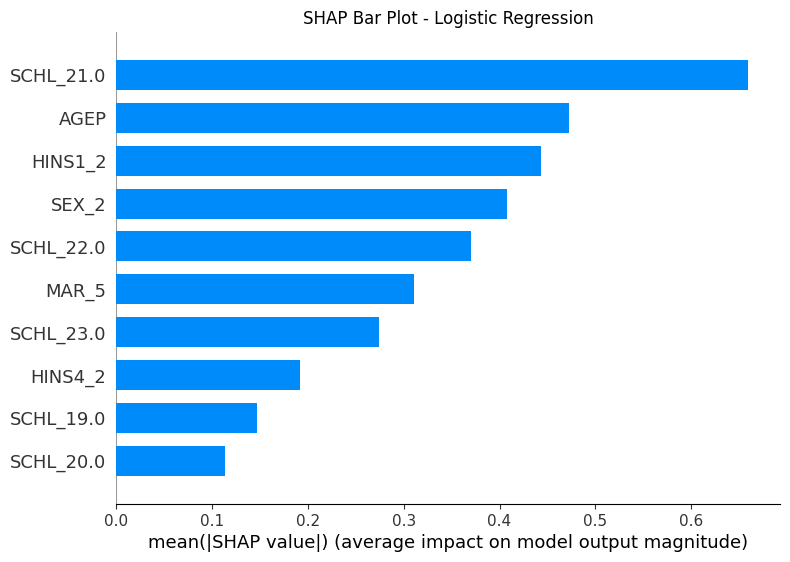

In [112]:
############# SHAP ################
## Logistic Regression, bar plot: 
import shap
import matplotlib.pyplot as plt

# Assuming clf is your trained model and X_train, X_test are defined
explainer = shap.LinearExplainer(LogR, feature_names=X_train.columns,masker = shap.maskers.Independent(X_train)) 
shap_values = explainer.shap_values(X_test)

# Now you can proceed to plot the SHAP bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False, max_display = 10)

# Customize the colors of the bars using Matplotlib
#custom_color = 'green'  # Example color, customize as needed
#for bar in plt.gca().patches:
#    bar.set_facecolor(custom_color)  # Apply color to each bar

plt.title("SHAP Bar Plot - Logistic Regression")
plt.show()



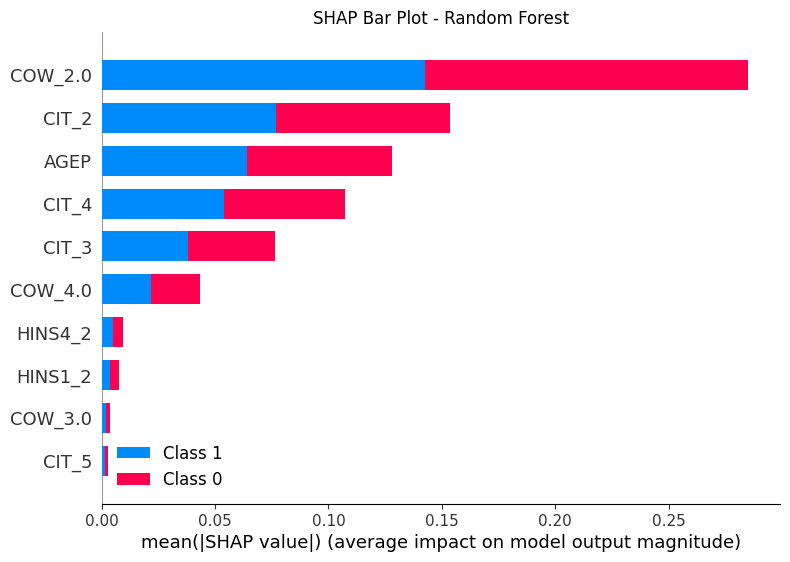

In [113]:
import shap
import matplotlib.pyplot as plt

# Assuming clf is your trained model and X_train, X_test are defined
explainer = shap.TreeExplainer(clf, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_test)

# Now you can proceed to plot the SHAP bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False, max_display = 10)

# Customize the colors of the bars using Matplotlib
#custom_color = 'green'  # Example color, customize as needed
#for bar in plt.gca().patches:
#    bar.set_facecolor(custom_color)  # Apply color to each bar

plt.title("SHAP Bar Plot - Random Forest")
plt.show()


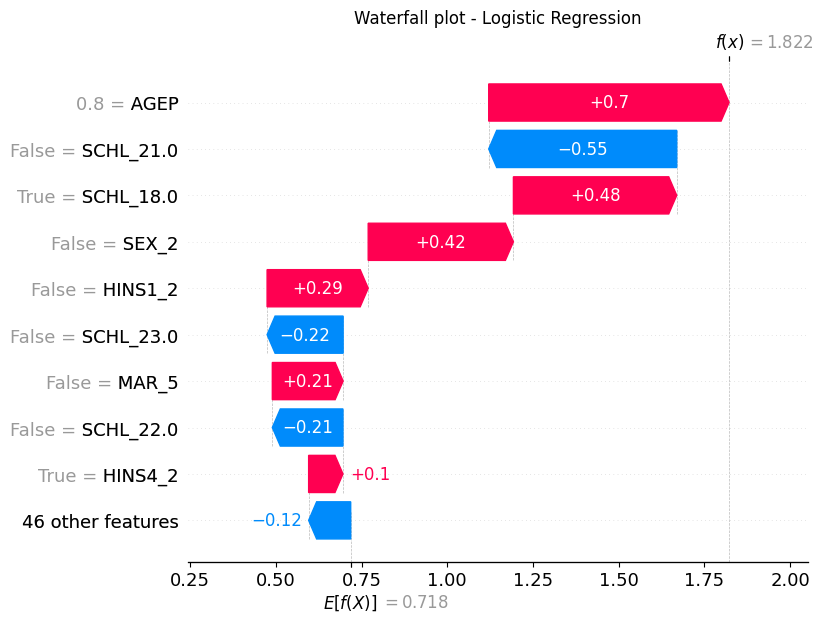

In [57]:
############# SHAP ################
## Logistic Regression, Waterfall plot: 
shap.plots.waterfall(shap_values_LogR[0], show = False)
plt.title("Waterfall plot - Logistic Regression")
plt.show()




In [58]:
print(shap_values_LogR.values)

[[0.7010765408627789 0.2948406046029334 -0.014925054362118967 ...
  0.013217261112555941 -0.0 0.039519928137541335]
 [-0.3769308655540073 0.2948406046029334 -0.014925054362118967 ...
  0.013217261112555941 -0.0 0.039519928137541335]
 [-0.3769308655540073 0.2948406046029334 0.09988305611571924 ...
  0.013217261112555941 -0.0 0.039519928137541335]
 ...
 [0.8125945484231362 0.2948406046029334 -0.014925054362118967 ...
  0.013217261112555941 -0.0 -0.052386881484647804]
 [0.7382492100495647 -0.7218511354071817 0.09988305611571924 ...
  0.013217261112555941 -0.0 -0.052386881484647804]
 [0.4036951873684931 0.2948406046029334 -0.014925054362118967 ...
  0.013217261112555941 -0.0 0.039519928137541335]]


In [59]:
shap.initjs()
from IPython.display import HTML
print("                                                                                                                          SHAP forceplot - Logistic Regression                    ")
force_plot = shap.plots.force(shap_values_LogR[0], link = "logit")
# Customize the colors in the HTML representation of the force plot
force_plot

                                                                                                                          SHAP forceplot - Logistic Regression                    


In [60]:
from matplotlib import colormaps

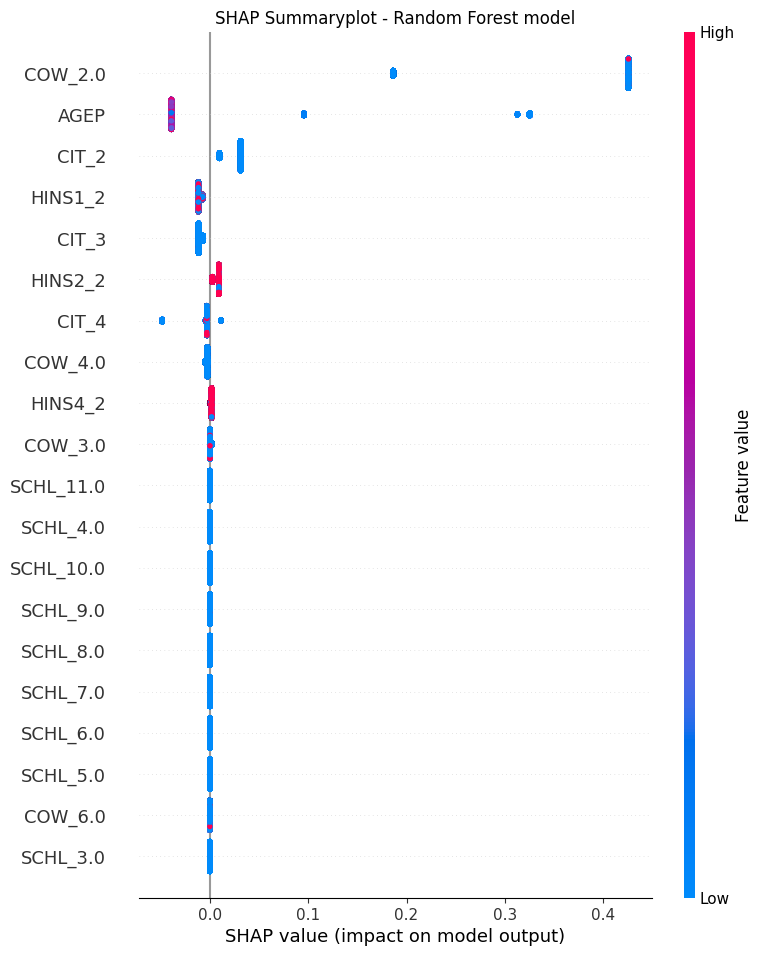

In [61]:
# explain all the predictions in the test set
ex = shap.TreeExplainer(tree_in_forest)
shap_values = ex.shap_values(X_test)
# Generate the SHAP summary plot
shap.summary_plot(shap_values[0], X_test, feature_names=data.columns, show=False)

# Customize the colors of the bars
custom_colors = plt.cm.viridis(np.linspace(0, 1, len(data.columns)))  # Generate custom colors
for patch, color in zip(plt.gca().patches, custom_colors):
    patch.set_facecolor(color)  # Set custom color for each bar

plt.title("SHAP Summaryplot - Random Forest model")
plt.show()

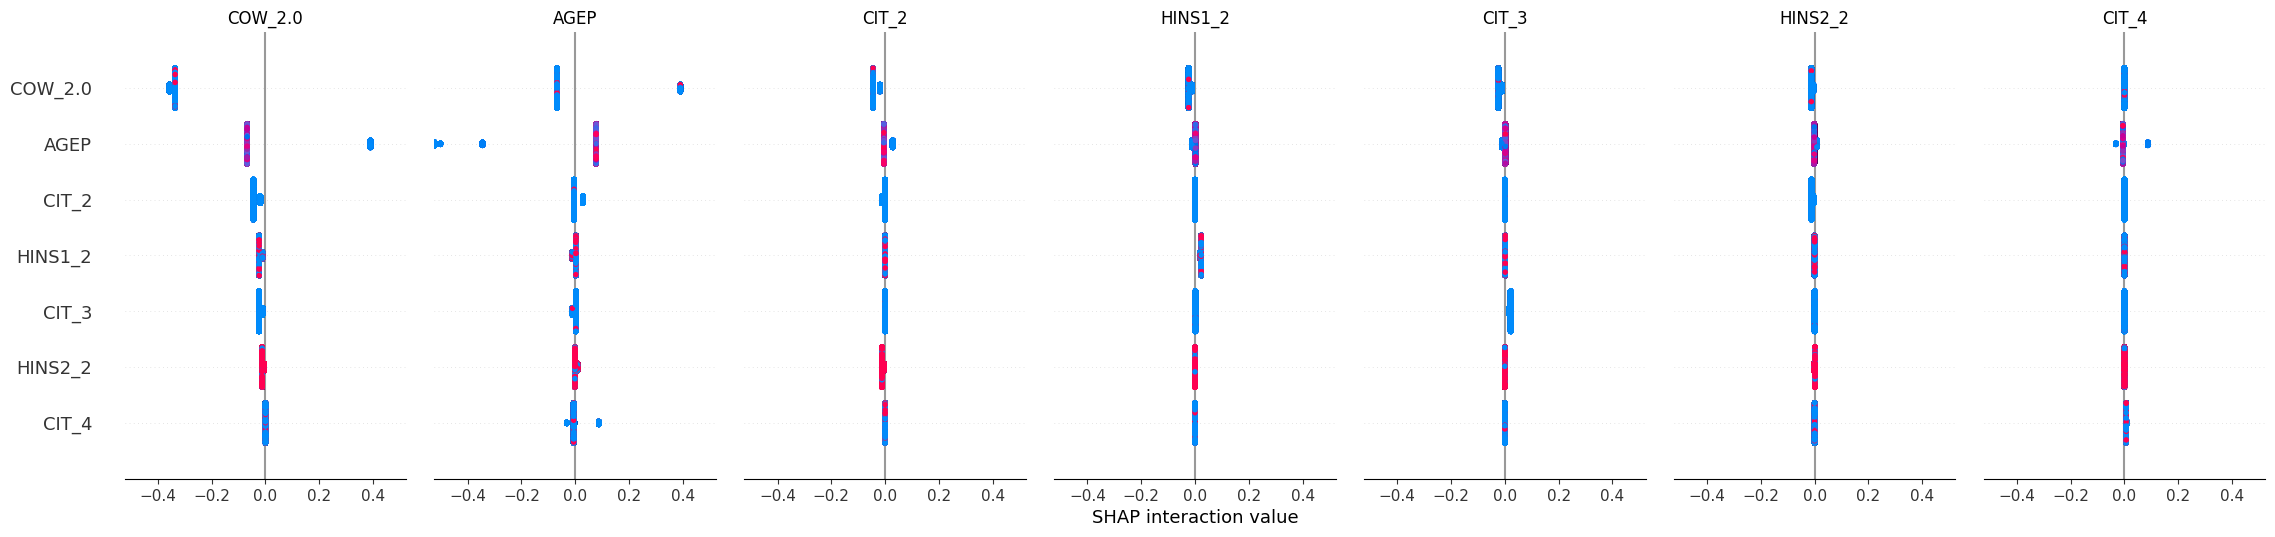

In [62]:

# Create the SHAP summary plot

explainer = shap.TreeExplainer(tree_in_forest, model_output = "raw")
shap_interaction_values = explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values[1], X_test, show = False)

# Get the current figure
fig = plt.gcf()

# Set the figure size, to avoid having overs
fig.set_size_inches(24, 5)

# Show the plot
#plt.title("SHAP Overview plot - Tree Model")
plt.show()